In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
import pandas as pd
import torch

/tmp/ipykernel_90522/866551177.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [4]:
from sklearn.model_selection import train_test_split


DIMENSIONS = (28, 28)
CHANNELS = 1  # grayscale
INPUT_SIZE = DIMENSIONS[0] * DIMENSIONS[1]
OUTPUT_SIZE = 10

def transform_data(
        is_convolutional: bool,
        x: pd.DataFrame,
        y: pd.Series | None = None) -> tuple[torch.tensor, torch.tensor]:
    """
    Transforms the data. Returns a tuple of (x, y) where x is a tensor of the features and y is a
    tensor of the labels.

    Args:
        is_convolutional: A boolean indicating whether the model is convolutional.
        x: A dataframe of the features.
        y: A series of the labels.
    """
    x = torch.tensor(x.values, dtype=torch.float32)
    # Normalize the tensor
    x_min = x.min()
    x_max = x.max()
    x = (x - x_min) / (x_max - x_min)
    assert x.min() == 0
    assert x.max() == 1
    if is_convolutional:
        # Reshape data to have channel dimension
        # MNIST images are 28x28, so we reshape them to [batch_size, 1, 28, 28]
        x = x.reshape(-1, CHANNELS, DIMENSIONS[0], DIMENSIONS[1])
    if y is not None:
        y = torch.tensor(y.astype(int).values, dtype=torch.long)
    return x, y


def get_data():  # noqa
    """Function is required by and called from `model_pipeline()`."""
    x, y = fetch_openml('mnist_784', version=1, return_X_y=True, parser='auto')
    x, y = transform_data(is_convolutional=False, x=x, y=y)
    # 80% train; 10% validation; 10% test
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42)
    print(f"Training set  : X-{x_train.shape}, y-{y_train.shape}")
    print(f"Validation set: X-{x_val.shape}, y-{y_val.shape}")
    print(f"Test set      : X-{x_test.shape}, y-{y_test.shape}")
    return x_train, x_val, x_test, y_train, y_val, y_test

x_train, x_val, x_test, y_train, y_val, y_test = get_data()

Training set  : X-torch.Size([56000, 784]), y-torch.Size([56000])
Validation set: X-torch.Size([7000, 784]), y-torch.Size([7000])
Test set      : X-torch.Size([7000, 784]), y-torch.Size([7000])


In [6]:
OUTPUT_SIZE

10

In [11]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, TensorDataset

class MLP(nn.Module):
    """A Multilayer Perceptron (MLP) model in PyTorch with one hidden layer."""

    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(INPUT_SIZE, 100)
        self.output = nn.Linear(100, OUTPUT_SIZE)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the network.

        Args:
            x: Input tensor.

        Returns:
            Tensor after passing through the layers and activations.
        """
        x = self.relu(self.hidden(x))
        return self.softmax(self.output(x))

learning_rate = 0.01
epochs = 15
batch_size = 32

dataset = TensorDataset(x_train, y_train)
# not shuffling so that is more similar to numpy implementation
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

model = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
losses = []

for epoch in range(epochs):
    for i, (inputs, targets) in enumerate(dataloader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        if i % 200 == 0:
            losses.append(loss.item())
            print(f"Epoch {epoch}, batch {i:04}, loss {loss}")
print(f"Epoch {epoch}, batch {i:04}, loss {loss}")

Epoch 0, batch 0000, loss 2.305325746536255
Epoch 0, batch 0200, loss 2.2929677963256836
Epoch 0, batch 0400, loss 2.2898635864257812
Epoch 0, batch 0600, loss 2.2750356197357178
Epoch 0, batch 0800, loss 2.2872016429901123
Epoch 0, batch 1000, loss 2.2277984619140625
Epoch 0, batch 1200, loss 2.26682710647583
Epoch 0, batch 1400, loss 2.274217128753662
Epoch 0, batch 1600, loss 2.1692183017730713
Epoch 1, batch 0000, loss 2.219090223312378
Epoch 1, batch 0200, loss 2.0926923751831055
Epoch 1, batch 0400, loss 2.033102512359619
Epoch 1, batch 0600, loss 1.91134774684906
Epoch 1, batch 0800, loss 2.0595805644989014
Epoch 1, batch 1000, loss 1.8454954624176025
Epoch 1, batch 1200, loss 1.9961642026901245
Epoch 1, batch 1400, loss 1.9972368478775024
Epoch 1, batch 1600, loss 2.0112831592559814
Epoch 2, batch 0000, loss 1.9502160549163818
Epoch 2, batch 0200, loss 1.8106290102005005
Epoch 2, batch 0400, loss 1.777761697769165
Epoch 2, batch 0600, loss 1.6230388879776
Epoch 2, batch 0800, l

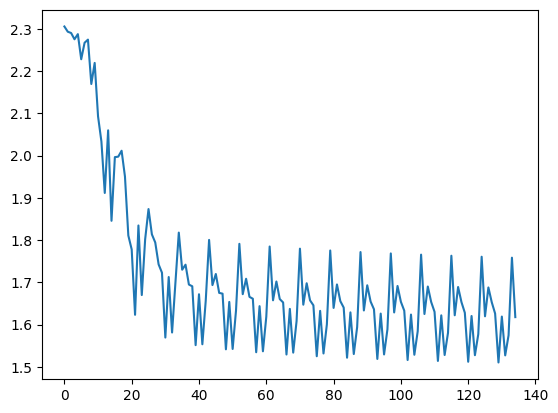

In [12]:
# plot losses over time
plt.plot(losses)

In [14]:
y_test

tensor([5, 7, 5,  ..., 3, 7, 1])

In [18]:
# test the model
with torch.no_grad():
    outputs = model(x_test)
    loss = criterion(outputs, y_test)
    print(f"Test loss: {loss}")
    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == y_test).sum().item() / y_test.size(0)
    print(f"Test accuracy: {accuracy:.2f}")

Test loss: 1.6315670013427734
Test accuracy: 0.84


Text(0.5, 1.0, 'Count of Misclassified Samples by Class')

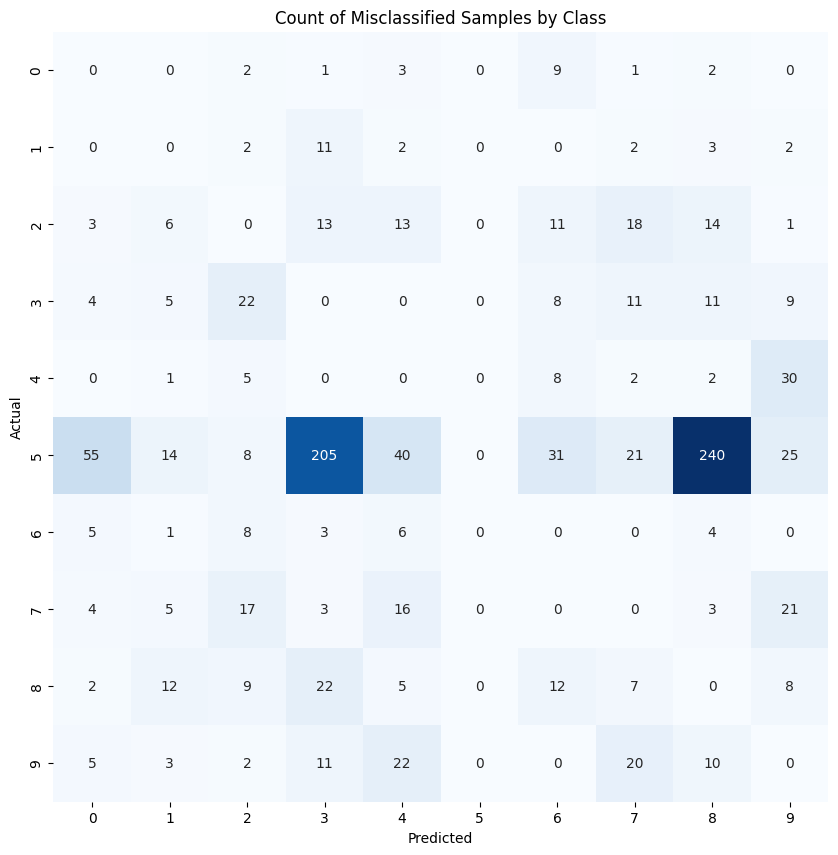

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, predicted)
# remove the diagonal values (correct predictions) for better visualization
np.fill_diagonal(cm, 0)
fig = plt.figure(figsize=(OUTPUT_SIZE, OUTPUT_SIZE))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Count of Misclassified Samples by Class')